## Fitness Center Churn Analysis

##### In this Analysis we had the membership data of a Fitness Center. The Fitner Center Manager was having below issues:
1. The center would see a lot of members joining in the begining of month but people would leave in the later part of year.
2. Manager wanted to reduce the Churn and create a strategy to tackle it.

The variables in the Data Set included following variables:
1. enrolldt: Enrollment Date
2. price: It shows the membership price to be paid by member.
3. downpmt: It shows the downpayment made by members at the time of enrollment.
4. monthdue
5. pmttype: The Payment type like Credit Card, debit card, cheque etc. 
6. use: Tells us the usage of fitness center
7. age: Age of member
8. gender: Gender of Member
9. default: Whether person defaults on payment or not.

In [3]:
# Importing required packages
import pandas as pd
import datetime
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


In [4]:
# Importing the Data Set
data = pd.read_excel("Fitness Club Data.xlsx")
data.head()

,enrolldt,price,downpmt,monthdue,pmttype,use,age,gender,default
0,19970101,2178.85,250.00,6.00,4,1,0,2,0
1,19970101,1543.65,1543.65,6.00,1,0,0,2,0
2,19970101,1107.67,125.00,5.00,1,0,0,2,0
3,19970101,2113.25,118.00,5.89,1,0,19,2,0
4,19970101,699.00,29.00,5.50,4,1,21,1,0


In [5]:
# Checking the info of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24843 entries, 0 to 24842
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   enrolldt  24843 non-null  int64  
 1   price     24843 non-null  float64
 2   downpmt   24843 non-null  float64
 3   monthdue  24843 non-null  float64
 4   pmttype   24843 non-null  int64  
 5   use       24843 non-null  int64  
 6   age       24843 non-null  int64  
 7   gender    24843 non-null  int64  
 8   default   24843 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 1.7 MB


So first we need to change the enrollment date variable into date.

In [6]:
# Changing the Enrollment date to Date Time Format and extracting new features 
data['enroll_date'] = pd.to_datetime(data['enrolldt'], format='%Y%m%d', errors='ignore')

# Extracting Month. 1-12 signify the months from Jan to Dec
data['enroll_month'] = data['enroll_date'].dt.month

# Extracting Weekday. 0-6 sinify weekdays from Monday being 0 to Sunday being 6
data['enroll_weekday'] = data['enroll_date'].dt.day

# Extracting quarter number
data['enroll_quarter'] = data['enroll_date'].dt.quarter



# Checking the Head
data.head()

,enrolldt,price,downpmt,monthdue,pmttype,use,age,gender,default,enroll_date,enroll_month,enroll_weekday,enroll_quarter
0,19970101,2178.85,250.00,6.00,4,1,0,2,0,1997-01-01,1,1,1
1,19970101,1543.65,1543.65,6.00,1,0,0,2,0,1997-01-01,1,1,1
2,19970101,1107.67,125.00,5.00,1,0,0,2,0,1997-01-01,1,1,1
3,19970101,2113.25,118.00,5.89,1,0,19,2,0,1997-01-01,1,1,1
4,19970101,699.00,29.00,5.50,4,1,21,1,0,1997-01-01,1,1,1


In [7]:
data[['price', 'downpmt', 'monthdue', 'pmttype', 'use', 'age']].describe()

,price,downpmt,monthdue,pmttype,use,age
count,24843.000000,24843.000000,24843.000000,24843.000000,24843.000000,24843.000000
mean,1003.658899,199.824535,8.287290,3.093225,1.944371,29.203317
std,439.224768,335.437237,7.108381,1.560034,2.315550,13.277721
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,699.000000,49.000000,5.500000,1.000000,0.000000,22.000000
50%,999.000000,100.000000,6.000000,3.000000,1.000000,28.000000
75%,1249.000000,175.000000,9.000000,4.000000,3.000000,36.000000
max,9371.250000,9371.250000,120.000000,5.000000,8.000000,99.000000


Key Take aways:
1. There are few customers who has not paid any price. We need to remove those customers, as it does not make sense to analyse these members. Members having zero price might be possible if they have a coupon or something, which we are ignoring here as we see that in data we also have 0.01 as price which we can assume as complimentary membership for fitness center.
2. Age variable contains few anomalies which we need to correct. Such as 0 and 99 ages.

In [8]:
# Dropping the rows with price as zero. 
data = data[data['price'] != 0] 
data.shape

(24772, 13)

In [17]:
# Finding the counts of people who have made downpayment equal to price
data[data['price'] == data['downpmt']].shape

(3709, 13)

These people have already paid their dues and have no option to churn so removing these customers.

In [20]:
data = data[data['price'] != data['downpmt']]
data.shape

(21063, 13)

In [21]:
# Checking what percent of data with different suspicious ages
print( "Data percentage with age as 0 is " , round((data[data['age'] == 0]['age'].count()/data['age'].count())*100,3))
print( "Data percentage with age as 99 is " , round((data[data['age'] == 99]['age'].count()/data['age'].count())*100,3))
print( "Data percentage with age less than 10 is " , round((data[data['age'] < 10]['age'].count()/data['age'].count())*100,3))
print( "Data percentage with age greater than 65 " , round((data[data['age'] > 70]['age'].count()/data['age'].count())*100,3))

Data percentage with age as 0 is  3.722
Data percentage with age as 99 is  0.0
Data percentage with age less than 10 is  6.129
Data percentage with age greater than 65  0.266


I am assuming its not just a Gym but includes other facilities as well like pool, playing courts or grounds. Hence its reaosnable to take people between age group 10 to 70.

In [22]:
# Keeping only the rows with age between 10 to 70
data = data[data['age'].between(10, 70)]
data.shape

(19716, 13)

In [23]:
# Creating Bins for age
data['age_bin'] = pd.cut(x=data['age'], bins=[10, 20, 30, 40, 50, 60, 70] ,
                         labels = ['10_20', '21_30', '31_40', '41_50', '51_60' ,'61_70'],
                         include_lowest=True)
data.tail()
data['age_bin'].value_counts()

21_30    9800
31_40    4739
41_50    2119
10_20    2064
51_60     774
61_70     220
Name: age_bin, dtype: int64

In [24]:
# Checking the default and non default percent in each age group
pd.crosstab(data['age_bin'], data['default']).apply(lambda r: round(((r/r.sum())*100),2), axis=1)

default,0,1
age_bin,,
10_20,87.45,12.55
21_30,83.44,16.56
31_40,86.81,13.19
41_50,92.26,7.74
51_60,94.19,5.81
61_70,97.73,2.27


In [64]:
pd.crosstab(data['age_bin'], data['pmttype']).apply(lambda r: round(((r/r.sum())*100),2), axis=1)

pmttype,1,3,4,5
age_bin,,,,
10_20,20.98,31.59,25.63,21.80
21_30,24.98,22.33,26.42,26.28
31_40,21.82,20.91,29.69,27.58
41_50,17.46,16.47,33.65,32.42
51_60,17.70,17.44,31.27,33.59
61_70,16.82,14.09,31.82,37.27


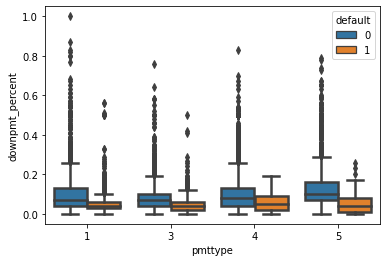

In [66]:
# Boxplot for Price in each age group between defaulter and non defaulter.
ax = sns.boxplot(x="pmttype", y="downpmt_percent", hue="default", data=data, linewidth=2.5)

In [25]:
# Checking the Use variable
data['use'].value_counts()

0    7685
1    4716
6    1965
3    1945
4    1197
5     897
7     597
2     511
8     203
Name: use, dtype: int64

It seems to be some categorical variable

In [26]:
# Checking the Month Due Variable
data['monthdue'].value_counts()

6.00     2537
8.00     2483
4.00     2411
5.50     2184
9.00     1025
         ... 
2.19        1
20.90       1
3.76        1
12.97       1
8.48        1
Name: monthdue, Length: 301, dtype: int64

It is showing maybe number of months the payment is due. Lets bin the variable and see how it behaves between defaulter and non defaulter.

In [27]:
# Creating Bins for monthdue
data['monthdue_bin'] = pd.cut(x=data['monthdue'], bins=[0, 2, 4, 6, 8, 10, 15, 40, 120] ,
                         labels = ['0_2', '2_4', '4_6', '6_8', '8_10' ,'10_15','15_40','40+'],
                         include_lowest=True)
data.tail()
data['monthdue_bin'].value_counts()

4_6      5974
6_8      3795
2_4      3455
8_10     2248
10_15    1815
15_40    1506
0_2       829
40+        94
Name: monthdue_bin, dtype: int64

In [28]:
# Checking the cross tab for Monthdue bin and default percent in each group
pd.crosstab(data['monthdue_bin'], data['default']).apply(lambda r: round(((r/r.sum())*100),2), axis=1)

default,0,1
monthdue_bin,,
0_2,96.62,3.38
2_4,87.67,12.33
4_6,80.33,19.67
6_8,84.01,15.99
8_10,94.08,5.92
10_15,90.69,9.31
15_40,89.24,10.76
40+,77.66,22.34


### Visualization

##### Visualizing the boxplot for all the numeric variables

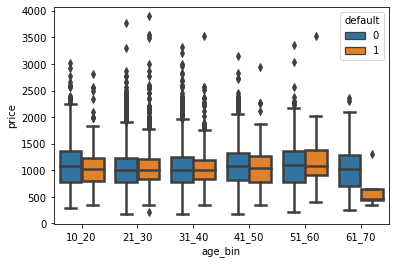

In [29]:
# Boxplot for Price in each age group between defaulter and non defaulter.
ax = sns.boxplot(x="age_bin", y="price", hue="default", data=data, linewidth=2.5)

There are lot of outliers. But on average the membership price is similar for all. 

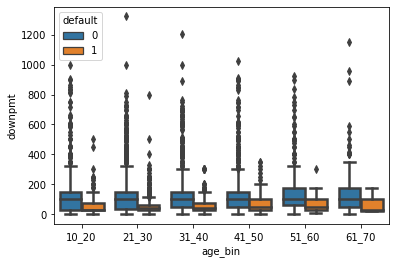

In [30]:
# Boxplot for downpayment in each age group between defaulter and non defaulter.
ax = sns.boxplot(x="age_bin", y="downpmt", hue="default", data=data, linewidth=2.5)

Again there are lot of outliers in the down payment. But one interesting thing to note is that non-defaulters do make a higher down payment in comparison to defaulters. Thus what we should look is the ratio of down payment to price to get a clear idea about it. 

In [31]:
# Creating new variable of DownPayment Percent
data['downpmt_percent'] = (data.downpmt/data.price).round(2)
data.head()

,enrolldt,price,downpmt,monthdue,pmttype,use,age,gender,default,enroll_date,enroll_month,enroll_weekday,enroll_quarter,age_bin,monthdue_bin,downpmt_percent
3,19970101,2113.25,118.0,5.89,1,0,19,2,0,1997-01-01,1,1,1,10_20,4_6,0.06
4,19970101,699.00,29.0,5.50,4,1,21,1,0,1997-01-01,1,1,1,21_30,4_6,0.04
5,19970101,843.27,100.0,5.00,4,6,22,1,0,1997-01-01,1,1,1,21_30,4_6,0.12
6,19970101,499.00,100.0,4.00,4,0,25,1,0,1997-01-01,1,1,1,21_30,2_4,0.20
7,19970101,1531.53,30.0,5.50,4,1,26,1,0,1997-01-01,1,1,1,21_30,4_6,0.02


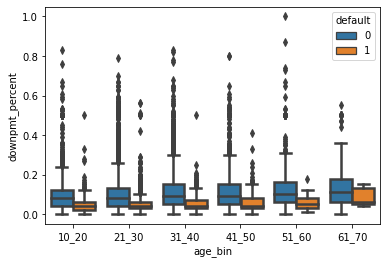

In [32]:
# Boxplot for downpayment percent in each age group between defaulter and non defaulter.
ax = sns.boxplot(x="age_bin", y="downpmt_percent", hue="default", data=data, linewidth=2.5)

This clearly shows that the people who make a higher downpayment as a percent of membership price are less likely to default. This is a sunk cost fallacy, which members might be showcasing

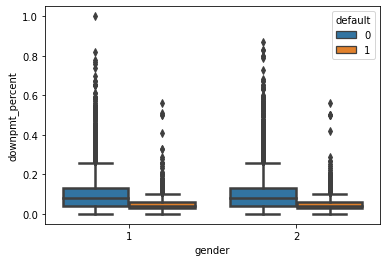

In [33]:
# Boxplot for gender in each gender group between defaulter and non defaulter.
ax = sns.boxplot(x="gender", y="downpmt_percent", hue="default", data=data, linewidth=2.5)

The same behaviour is shown among gender as well. People who make a higher downpayment as a percent of membership price are less likely to default. This is a sunk cost fallacy, which members might be showcasing

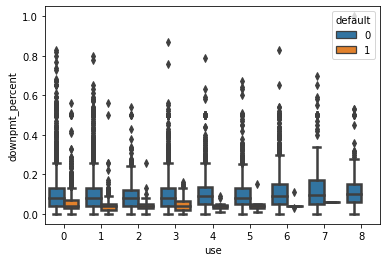

In [34]:
# Boxplot for use in each use between defaulter and non defaulter.
ax = sns.boxplot(x="use", y="downpmt_percent", hue="default", data=data, linewidth=2.5)

In [62]:
pd.crosstab(data['use'], data['default']).apply(lambda r: round(((r/r.sum())*100),2), axis=1)

default,0,1
use,,
0,74.21,25.79
1,87.36,12.64
2,92.95,7.05
3,95.78,4.22
4,98.83,1.17
5,99.44,0.56
6,99.75,0.25
7,99.83,0.17
8,100.00,0.00


In [63]:
pd.crosstab(data['use'], data['default'])

default,0,1
use,,
0,5703,1982
1,4120,596
2,475,36
3,1863,82
4,1183,14
5,892,5
6,1960,5
7,596,1
8,203,0


This gives us some interesting insights about the use variable:
1. Its some categorical variable showing how people use the center. 0 means no use and 8 means maximum use.
2. Defaulters are usually people who don't use the fitness center much. 
3. As people begin using the gym more the default rate reduces. 

#### Visualizing the Date Variable 

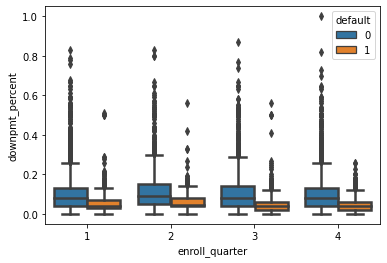

In [35]:
# Boxplot for downpayment percent in each enroll quarter between defaulter and non defaulter.
ax = sns.boxplot(x="enroll_quarter", y="downpmt_percent", hue= 'default' ,data=data, linewidth=2.5)

Thus people who enroll in the second quarter do pay a higher down payment as a percent of price in both defaulters and non defaulters.

### Logistic Regression Model

In [36]:
# Create dummy variables for the 
churn_data = pd.get_dummies(data, columns = ['pmttype', 'use', 'age_bin','monthdue_bin','enroll_quarter'],
                            drop_first = True, 
                            prefix = ['pmttype', 'use','age_bin','monthdue_bin','enroll_quarter'])


In [37]:
# Dropping Few Variables
churn_data = churn_data.drop(['enrolldt','enroll_date','enroll_weekday'], axis = 1)


We are using stratify to ensure that the distribution is same in the train and test dataset.

In [38]:
# Split data, creating two dataframes - one with all features (X) and another one - with just default variable (y)
y = churn_data['default']
X = churn_data.drop('default', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100, stratify= y)

In [39]:
# Create and fitting a model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [40]:
# Predict the model output using testing data
y_pred = logreg.predict(X_test)

# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[3341   59]
 [ 456   88]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      3400
           1       0.60      0.16      0.25       544

    accuracy                           0.87      3944
   macro avg       0.74      0.57      0.59      3944
weighted avg       0.84      0.87      0.84      3944



Precision is the ratio between the True Positives and all the Positives. For our problem statement, that would be the measure of members that we correctly identify having defaulted out of all the defaults. 

The recall is the measure of our model correctly identifying True Positives. Thus, for all the members who actually have defaulted, recall tells us how many we correctly identified as defaulted.


Thus Recall is more important in our case as we would want to identify the correct members who are going to default. 

Here we see a precision of 60% and a recall of 16% for the default class in a basic logistic regression model. 


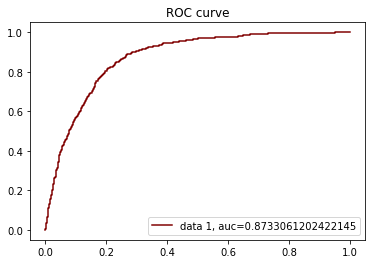

In [41]:
# Creating a ROC curve
from sklearn import metrics
y_pred_proba = logreg.predict_proba(X_test)[::, 1]
fpr, tpr, _  = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc), color = 'maroon')
plt.legend(loc = 4)
plt.title('ROC curve')
plt.show()

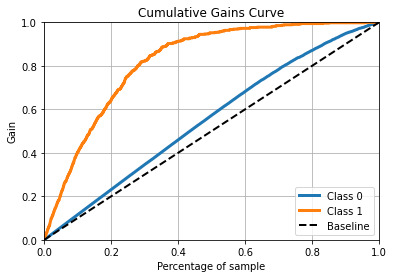

In [42]:
# Create a chart
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test,logreg.predict_proba(X_test))
plt.show()

In [43]:
#Feature Selection
# Getting the best coefficients
feature_imp = logreg.coef_
coef_table = pd.DataFrame({"feature_names":X_train.columns, "Beta":feature_imp[0], "AbsBeta":abs(feature_imp[0])})
# Get the sorted values
coef_table = coef_table.sort_values(by = 'AbsBeta', ascending = False)
print("The most important features in the model are: \n")
coef_table.head()

The most important features in the model are: 



,feature_names,Beta,AbsBeta
8,pmttype_4,-1.973621,1.973621
9,pmttype_5,-1.429110,1.429110
15,use_6,-0.728440,0.728440
4,gender,-0.633313,0.633313
12,use_3,-0.596999,0.596999


### Using Corss Validation to train the Model

In [44]:
from sklearn.linear_model import LogisticRegressionCV

In [45]:
cv_log = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [46]:
# Predict the model output using testing data
y_pred = cv_log.predict(X_test)

# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[3267  133]
 [ 290  254]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      3400
           1       0.66      0.47      0.55       544

    accuracy                           0.89      3944
   macro avg       0.79      0.71      0.74      3944
weighted avg       0.88      0.89      0.88      3944



So we have improved our precision score by 6% from 60% in a simple Logistic Model to 66% using Cross Validation.
And our recall score by 31%% from 16% in simple logistic model to 47% using Cross Validation

# Using Smote to OverSample the Minority Data and Then Training the Simple Logistic Model

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [51]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
from imblearn.over_sampling import SMOTE 
#sm = SMOTE(random_state = 2) 
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=100)
X_res, y_res = sm.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0))) 

Before OverSampling, counts of label '1': 2177
Before OverSampling, counts of label '0': 13595 

After OverSampling, the shape of train_X: (33990, 33)
After OverSampling, the shape of train_y: (33990,) 

After OverSampling, counts of label '1': 16995
After OverSampling, counts of label '0': 16995


In [52]:
# Create and fitting a  simple model
logreg1 = LogisticRegression()
logreg1.fit(X_res, y_res)

# Predict the model output using testing data
y_pred = logreg1.predict(X_test)

# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[2963  437]
 [ 139  405]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3400
           1       0.48      0.74      0.58       544

    accuracy                           0.85      3944
   macro avg       0.72      0.81      0.75      3944
weighted avg       0.89      0.85      0.87      3944



C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


So we have improved our recall score by 27% from 47% in logistic model using cross validation to 74% using Cross Validation

In [53]:
# Using Cross Validation to train the model
cv_log1 = LogisticRegressionCV(cv=5, random_state=0).fit(X_res, y_res)

# Predict the model output using testing data
y_pred = cv_log1.predict(X_test)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [54]:
# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[3017  383]
 [ 136  408]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      3400
           1       0.52      0.75      0.61       544

    accuracy                           0.87      3944
   macro avg       0.74      0.82      0.77      3944
weighted avg       0.90      0.87      0.88      3944



So we have improved our recall score by 1% from 74% in logistic model using cross validation to 75% using Cross Validation 
with synthetic sampling 

### Using the near Miss Method for Smote Sampling

In [55]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 

Before Undersampling, counts of label '1': 2177
Before Undersampling, counts of label '0': 13595 

After Undersampling, the shape of train_X: (4354, 33)
After Undersampling, the shape of train_y: (4354,) 

After Undersampling, counts of label '1': 2177
After Undersampling, counts of label '0': 2177


In [56]:
# Create and fitting a model
logreg2 = LogisticRegression()
logreg2.fit(X_train_miss, y_train_miss.ravel())


# Predict the model output using testing data
y_pred = logreg2.predict(X_test)

# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[2287 1113]
 [  83  461]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.96      0.67      0.79      3400
           1       0.29      0.85      0.44       544

    accuracy                           0.70      3944
   macro avg       0.63      0.76      0.61      3944
weighted avg       0.87      0.70      0.74      3944



C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


So we have improved our recall score by 10% from 75% in logistic model using cross validation to 85% using Cross Validation with synthetic sampling

In [57]:
# Using Cross Validation to train the model
cv_log2 = LogisticRegressionCV(cv=5, random_state=0).fit(X_train_miss, y_train_miss.ravel())

# Predict the model output using testing data
y_pred = cv_log2.predict(X_test)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [58]:
# Printing the Confusion Matrix
print("The Confusion Matrix is \n \n", confusion_matrix(y_test, y_pred))
print("The Classification table is \n \n", classification_report(y_test, y_pred))

The Confusion Matrix is 
 
 [[2401  999]
 [  72  472]]
The Classification table is 
 
               precision    recall  f1-score   support

           0       0.97      0.71      0.82      3400
           1       0.32      0.87      0.47       544

    accuracy                           0.73      3944
   macro avg       0.65      0.79      0.64      3944
weighted avg       0.88      0.73      0.77      3944



So we have improved our recall score by 10% from 85% in logistic model using cross validation to 87% using Cross Validation with synthetic sampling

In [61]:
#Feature Selection
# Getting the best coefficients
feature_imp = cv_log2.coef_
coef_table = pd.DataFrame({"feature_names":X_train.columns, "Beta":feature_imp[0], "AbsBeta":abs(feature_imp[0])})
# Get the sorted values
coef_table = coef_table.sort_values(by = 'AbsBeta', ascending = False)
print("The most important features in the model are: \n")
coef_table

The most important features in the model are: 



,feature_names,Beta,AbsBeta
15,use_6,-4.259310,4.259310
8,pmttype_4,-3.944630,3.944630
13,use_4,-3.319194,3.319194
16,use_7,-3.210990,3.210990
14,use_5,-3.027901,3.027901
9,pmttype_5,-2.893298,2.893298
12,use_3,-2.054860,2.054860
17,use_8,-1.527314,1.527314
7,pmttype_3,-1.204363,1.204363
11,use_2,-1.146651,1.146651


So we have improved our recall score by 18% from 70% in logistic model using cross validation to 88% using Cross Validation with synthetic sampling

Thus overall we have the following Models with their Recall Scores:
1. Simple_Logistic_Model: 16%
2. Logistic_Model + Cross_Validation: 47% 
3. Smote + Logistic: 74%
4. Smote + Logistic + Cross_Validation: 75% 
5. Near_Miss_Smote + Logistic: 85%
6. Near_Miss_Smote + Logistic + CrossValidation: 87% 